Next steps:

Does the angles thing eventually change over time?


In [209]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import scipy.stats

import util

plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})

DPI = 50


FOLDER = "/Users/brendan/Projects/trails/data/"

datafiles = [
    "cost-angles|2025-11-10/data.json", # just added this
    "cost-angles|2025-11-07/data.json",
    "cost-angles|2025-08-01/data.json",
    "cost-angles|2025-08-02/data.json",
]

In [133]:
util.describe(df)


ratios: [100.0]
patch recovery: [0.001]
max costs: [1.25 1.5 2.0 3.0 5.0 9.0 17.0 33.0 65.0]
boundary conditions: ['SOLID']
num locations: [15 10 20]
random walker seeds: 4
random locations seeds: 2
patch recovery logic: ['LINEAR']
settings.searchStrategy : ['KANAI_SUZUKI']
steps: 20000
Index(['averageTravelCost', 'averageTravelLength', 'totalImprovement',
       'thresholdImprovement', 'steps', 'paths', 'weightedHeadings',
       'avgHeading', 'avgSquareHeading', 'patches',
       'settings.patchImprovement', 'settings.patchRecovery',
       'settings.maxCost', 'settings.boundaryConditions',
       'settings.numLocations', 'settings.randomSeedWalkers',
       'settings.randomSeedLocations', 'settings.recoveryLogic',
       'settings.improvementLogic', 'settings.searchStrategy', 'ratio', '90%',
       '95%', '99%'],
      dtype='object')


In [3]:
# this is all the regular data
dfs = [
    util.load_data(FOLDER + datafile) for datafile in datafiles
]
df = pd.concat(dfs)
# util.describe(df)

# this has the path plots
single_df = util.load_data(FOLDER + "cost-angles-single|2025-11-12/data.json")
# util.describe(single_df)

In [281]:
"""
Computes percentiles for all the max costs.
"""

MAX_COSTS = df["settings.maxCost"].unique()
PERCENTILES = [0.9, 0.95, 0.99]

def find_percentile(percentile, _headings):
    """
    Computes `percentile`th percentile of angle.
    """
    _headings = sorted(_headings, key=lambda h: h[0])
    total_weight = sum([h[1] for h in _headings])
    weights = [h[1] / total_weight for h in _headings]
    i = 0
    for cw in np.cumsum(weights):
        if cw >= percentile:
            return _headings[i][0] / np.pi * 180
        i += 1


cost_angles = {cost: {} for cost in MAX_COSTS}
for cost in MAX_COSTS:
    _df = df[
        (df["steps"] == STEPS) &
        (df["settings.maxCost"] == cost)
        # (df["settings.numLocations"] == 20)
    ]
    critical_angle = np.arccos(1 / cost) / np.pi * 180
    cost_angles[cost]["critical"] = critical_angle
    for percentile in PERCENTILES:
        cost_angles[cost][percentile] = find_percentile(percentile, _df["weightedHeadings"].explode())

In [186]:
sns.color_palette("rocket")

[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

In [172]:
EXAMPLE_COSTS = [1.5, 3.0, 65.0]
STEPS = 5000
COLORS = [sns.color_palette("rocket")[0], sns.color_palette("rocket")[2], sns.color_palette("rocket")[4]]

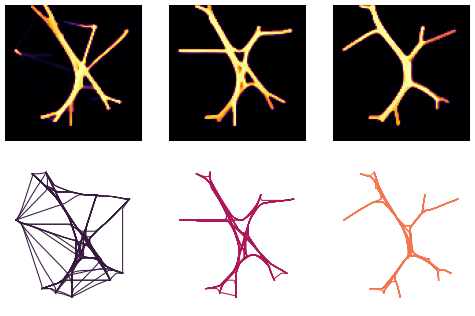

In [207]:
LENGTH = 4
fig, axs = plt.subplots(2, len(EXAMPLE_COSTS), figsize=(len(EXAMPLE_COSTS)*LENGTH, LENGTH * 2), dpi=DPI)
# plt.subplots_adjust(wspace=0.5, hspace=0.2)
for i, cost in enumerate(EXAMPLE_COSTS):
    row = single_df[(single_df["settings.maxCost"] == cost) & (single_df["steps"] == STEPS)].iloc[0]

    axs[0][i].imshow(np.reshape(row["patches"], (100, 100)), cmap="inferno")
    axs[0][i].axis('off')
    
    for path in row.paths:
        axs[1][i].plot([p[0] for p in path], [(100 - p[1]) for p in path], c=COLORS[i])
        axs[1][i].axis(False)
        axs[1][i].set_xlim(0, 100)
        axs[1][i].set_ylim(0, 100)
    # plt.show()

np.float64(56.732371014537016)

48.18968510422141 28.189523520436502
70.52877936550931 45.83662361046586
89.11849169319404 58.72817400090938


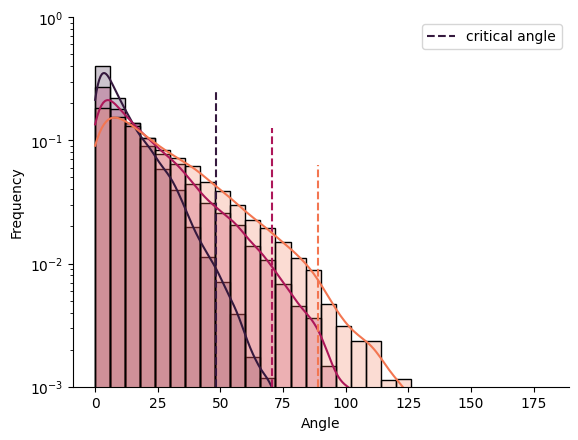

In [348]:
# maxCosts = [1.25, 1.5, 2.0, 3.0, 5.0, 9.0, 17.0, 33.0, 65.0]
for i, cost in enumerate(EXAMPLE_COSTS):
    _df = df[(df["steps"] == STEPS) & (df["settings.maxCost"] == cost)]
    headings = _df["weightedHeadings"].explode()

    print(cost_angles[cost]["critical"], cost_angles[cost][0.9])


    
    if i == 0:
        plt.axvline(x=cost_angles[cost]["critical"], ymin=0, ymax=(0.8 - i*0.1), linestyle='--', c=COLORS[i], label="critical angle")
    else:
        plt.axvline(x=cost_angles[cost]["critical"], ymin=0, ymax=(0.8 - i*0.1), linestyle='--', c=COLORS[i])

    # plt.axvline(x=cost_angles[cost][0.90], ymin=0, ymax=1, linestyle='-', c=COLORS[i], label=f"90th %")


    _weights = [h[1] for h in headings]
    weight_sum = sum(_weights)
    weights = [w / weight_sum for w in _weights]
    angles = [h[0] * 180 / np.pi for h in headings]

    p = sns.histplot(
        x=angles,
        weights=weights,
        bins=30,
        kde=True,
        binrange=(0.0, 180.0),
        log=True,
        alpha=0.25,
        color=COLORS[i],
        # label=f"cost: 1 + {cost - 1}"
    )
    plt.xlabel("Angle")
    plt.ylabel("Frequency")
    plt.ylim(10e-4, 10e-1)
    # plt.xlim(0, 0.8)
    # plt.axis(False)
plt.legend()


# for i, cost in enumerate(EXAMPLE_COSTS):
#     plt.scatter([cost_angles[cost][0.9]], [0.1], color=COLORS[i], s=200, alpha=1)

In [356]:
np.linspace(0, 100)

array([  0.        ,   2.04081633,   4.08163265,   6.12244898,
         8.16326531,  10.20408163,  12.24489796,  14.28571429,
        16.32653061,  18.36734694,  20.40816327,  22.44897959,
        24.48979592,  26.53061224,  28.57142857,  30.6122449 ,
        32.65306122,  34.69387755,  36.73469388,  38.7755102 ,
        40.81632653,  42.85714286,  44.89795918,  46.93877551,
        48.97959184,  51.02040816,  53.06122449,  55.10204082,
        57.14285714,  59.18367347,  61.2244898 ,  63.26530612,
        65.30612245,  67.34693878,  69.3877551 ,  71.42857143,
        73.46938776,  75.51020408,  77.55102041,  79.59183673,
        81.63265306,  83.67346939,  85.71428571,  87.75510204,
        89.79591837,  91.83673469,  93.87755102,  95.91836735,
        97.95918367, 100.        ])

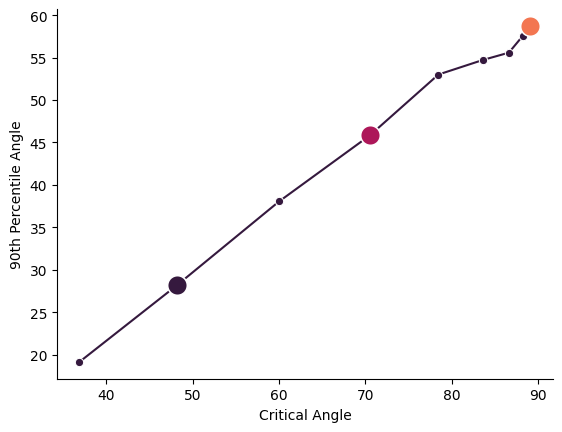

In [361]:
for p in [0.90]:
    sns.lineplot(
        y=[cost_angles[cost][p] for cost in MAX_COSTS],
        x=[cost_angles[cost]["critical"] for cost in MAX_COSTS],
        marker="o", c=COLORS[0])
    plt.xlabel("Critical Angle")
    plt.ylabel(f"{int(p*100)}th Percentile Angle")

    # draws a 1:1 straight line:
    # sns.lineplot(x=np.linspace(40, 100), y=np.linspace(40, 100))

    for i, cost in enumerate(EXAMPLE_COSTS):
        sns.scatterplot(
            x=[cost_angles[cost]["critical"]],
            y=[cost_angles[cost][p]],
            color=COLORS[i],
            s=200, alpha=1,
            zorder=10)


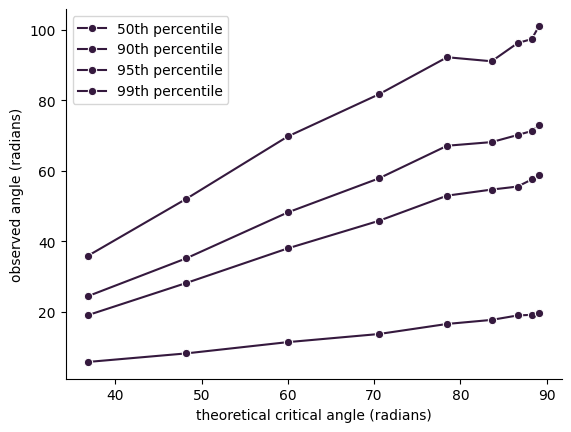

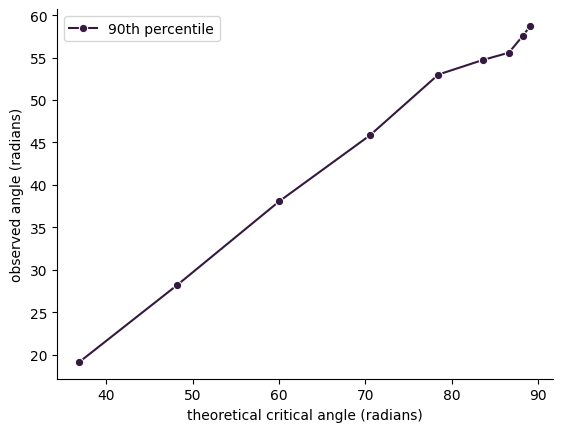

In [240]:

maxCosts = df["settings.maxCost"].unique()

angle_dict = {cost: () for cost in maxCosts}

cutoffs = [(cutoff, []) for cutoff in CUTOFFS]
angles = []
exponential_best_fits = []


for maxCost in maxCosts:
    _df = df[
        (df["steps"] == STEPS) &
        (df["settings.maxCost"] == maxCost)
        # (df["settings.numLocations"] == 20)
    ]
    
    critical_angle = np.arccos(1 / maxCost) / np.pi

    
    angles.append(angle)

    
    _headings = _df["weightedHeadings"].explode()
    _headings = _headings.to_list()
    _headings.sort(key=lambda h: h[0])

    headings = [h[0]/np.pi for h in _headings]
    # alt_headings = [h * -1 for h in headings]
    weights = [h[1] for h in _headings]

    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]

    
    for (cutoff, l) in cutoffs:
        i = 0
        for cw in np.cumsum(weights):
            if cw >= cutoff:
                l.append(headings[i])
                break
            i += 1

for c, l in cutoffs:
    sns.lineplot(x=[a * 180 for a in angles], y=[_l * 180 for _l in l], marker="o", c=COLORS[0], label=f"{int(100 * c)}th percentile")
    plt.xlabel("theoretical critical angle (radians)")
    plt.ylabel(f"observed angle (radians)")